 # **IPL SCORE PREDICTION**


# Import the Libraries

In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
import optuna
import seaborn as sns
import matplotlib.pyplot as plt 

/home/sowmya/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load the Dataset

In [2]:
# Loading the dataset
ipl_df = pd.read_csv(r'/home/sowmya/Zep Internship/IPL/ipl_data.csv')
ipl_df.head()

,mid,date,venue,bat_team,bowl_team,batsman,bowler,runs,wickets,overs,runs_last_5,wickets_last_5,striker,non-striker,total
0,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,SC Ganguly,P Kumar,1,0,0.1,1,0,0,0,222
1,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,1,0,0.2,1,0,0,0,222
2,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.2,2,0,0,0,222
3,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.3,2,0,0,0,222
4,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.4,2,0,0,0,222


In [3]:
ipl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76014 entries, 0 to 76013
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   mid             76014 non-null  int64  
 1   date            76014 non-null  object 
 2   venue           76014 non-null  object 
 3   bat_team        76014 non-null  object 
 4   bowl_team       76014 non-null  object 
 5   batsman         76014 non-null  object 
 6   bowler          76014 non-null  object 
 7   runs            76014 non-null  int64  
 8   wickets         76014 non-null  int64  
 9   overs           76014 non-null  float64
 10  runs_last_5     76014 non-null  int64  
 11  wickets_last_5  76014 non-null  int64  
 12  striker         76014 non-null  int64  
 13  non-striker     76014 non-null  int64  
 14  total           76014 non-null  int64  
dtypes: float64(1), int64(8), object(6)
memory usage: 8.7+ MB


# Data Pre-processing


1. Check for Null Values

In [4]:
# Check for Null Values
ipl_df.isnull().sum()

mid               0
date              0
venue             0
bat_team          0
bowl_team         0
batsman           0
bowler            0
runs              0
wickets           0
overs             0
runs_last_5       0
wickets_last_5    0
striker           0
non-striker       0
total             0
dtype: int64

2. Convert Date type from String to date

In [5]:
#Convert Date type from string to date
ipl_df['date'] = pd.to_datetime(ipl_df['date'])

In [6]:
ipl_df.shape

(76014, 15)

3. Drop Unnecessary Columns

As mid, striker, non-striker, batsman , bowler and venue are not needed for Score Prediction

In [7]:
# Drop the unecessary columns: mid, striker, non striker, venue, batsman, bowler
columns_to_drop = ['mid', 'striker', 'non-striker','batsman', 'bowler', 'venue']
ipl_df.drop(columns_to_drop, axis = 1, inplace = True)
ipl_df.head()

,date,bat_team,bowl_team,runs,wickets,overs,runs_last_5,wickets_last_5,total
0,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,1,0,0.1,1,0,222
1,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,1,0,0.2,1,0,222
2,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.2,2,0,222
3,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.3,2,0,222
4,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.4,2,0,222


4. Get Details of Current Team

In [8]:
# Get the teams
list(ipl_df['bat_team'].unique())

['Kolkata Knight Riders',
 'Chennai Super Kings',
 'Rajasthan Royals',
 'Mumbai Indians',
 'Deccan Chargers',
 'Kings XI Punjab',
 'Royal Challengers Bangalore',
 'Delhi Daredevils',
 'Kochi Tuskers Kerala',
 'Pune Warriors',
 'Sunrisers Hyderabad',
 'Rising Pune Supergiants',
 'Gujarat Lions',
 'Rising Pune Supergiant']

Teams 'Deccan Chargers', 'Kochi Tuskers Kerala', 'Gujarat Lions', 'Kochi Tuskers Kerala', 'Rising Pune Supergiant', 'Pune Warriors', 'Rising Pune Supergiants' are currenty either plays with different name or doesnt, so we just remove them and their data

In [9]:
# Remove old teams
team_list = list(ipl_df['bat_team'].unique())
old_teams = ['Deccan Chargers', 'Kochi Tuskers Kerala', 'Gujarat Lions', 'Kochi Tuskers Kerala', 'Rising Pune Supergiant', 'Pune Warriors', 'Rising Pune Supergiants']


In [10]:
#Get only current team and its data
current_teams = [teams for teams in team_list if teams not in old_teams] 

# Use the rows which have current_teams
ipl_df = ipl_df[ipl_df['bat_team'].isin(current_teams) & ipl_df['bowl_team'].isin(current_teams)]

In [11]:
ipl_df.head()

,date,bat_team,bowl_team,runs,wickets,overs,runs_last_5,wickets_last_5,total
0,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,1,0,0.1,1,0,222
1,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,1,0,0.2,1,0,222
2,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.2,2,0,222
3,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.3,2,0,222
4,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.4,2,0,222


In [12]:
#Check the team list with old teams removed
list(ipl_df['bat_team'].unique())

['Kolkata Knight Riders',
 'Chennai Super Kings',
 'Rajasthan Royals',
 'Mumbai Indians',
 'Kings XI Punjab',
 'Royal Challengers Bangalore',
 'Delhi Daredevils',
 'Sunrisers Hyderabad']

# Exploratory Data Analysis

In [13]:
ipl_df.head()

,date,bat_team,bowl_team,runs,wickets,overs,runs_last_5,wickets_last_5,total
0,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,1,0,0.1,1,0,222
1,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,1,0,0.2,1,0,222
2,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.2,2,0,222
3,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.3,2,0,222
4,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.4,2,0,222


Wicket Distribution

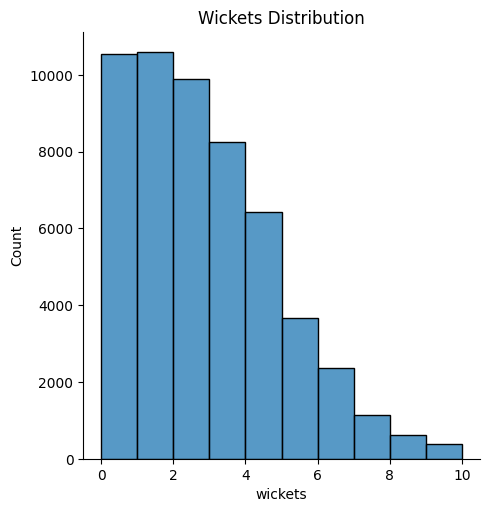

In [14]:
sns.displot(ipl_df['wickets'],kde=False,bins=10)
plt.title("Wickets Distribution")

plt.show()

Most of the wickets are between 0 to 3

Runs Distribution

* Lie between 150 to 175

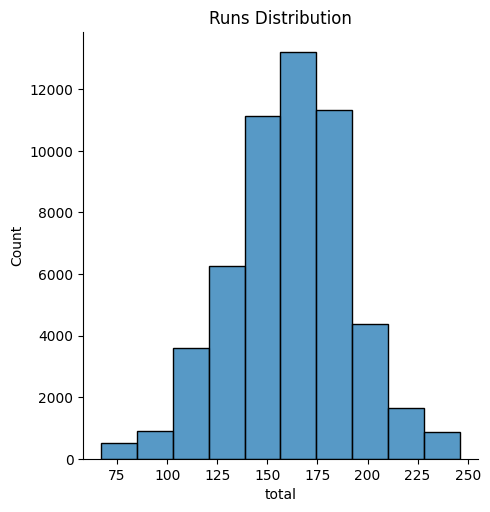

In [15]:
sns.displot(ipl_df['total'],kde=False,bins=10)
plt.title("Runs Distribution")

plt.show()

Correlation between variables

/tmp/ipykernel_7028/3406510519.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = ipl_df.corr()


<AxesSubplot: >

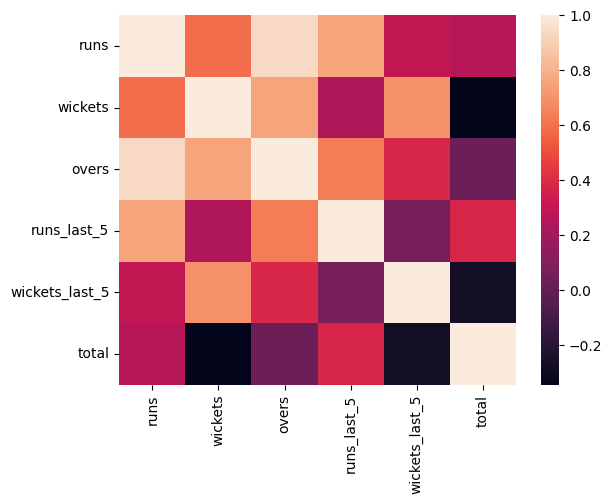

In [16]:
# Check the correlation betweeen the numerical features
corr = ipl_df.corr()


# Plot the heatmaps using seaborn
sns.heatmap(corr)

In [17]:
corr

,runs,wickets,overs,runs_last_5,wickets_last_5,total
runs,1.000000,0.585470,0.936672,0.756638,0.298999,0.260193
wickets,0.585470,1.000000,0.753480,0.240959,0.696528,-0.345314
overs,0.936672,0.753480,1.000000,0.633673,0.384388,0.025120
runs_last_5,0.756638,0.240959,0.633673,1.000000,0.067445,0.375733
wickets_last_5,0.298999,0.696528,0.384388,0.067445,1.000000,-0.277322
total,0.260193,-0.345314,0.025120,0.375733,-0.277322,1.000000


<b>RUNS, WICKETS</b> are highly correlated with OVERS.


# Prepare Data

Encode Categorical Columns
 * To Encode Categorical Columns here we will use OneHot Encoder


In [18]:
# get all the categorial columns
categorial_features = ['bat_team', 'bowl_team']

In [19]:
# Number of unique values in categorial_features

for cols in categorial_features:
    n_unique = np.unique(ipl_df[cols]).shape[0]
    print("Unique values in %s column is %d"%(cols, n_unique))

Unique values in bat_team column is 8
Unique values in bowl_team column is 8


In [20]:
#bat_team bowl_team features are few apply onehot encoder
nominal_cols = ['bat_team', 'bowl_team'] # onehot encode these columns

# One hot encode the columns and concat using pd.concat
ipl_df = pd.concat((ipl_df, pd.get_dummies(ipl_df[nominal_cols])), axis = 1)
ipl_df.head()

,date,bat_team,bowl_team,runs,wickets,overs,runs_last_5,wickets_last_5,total,bat_team_Chennai Super Kings,...,bat_team_Royal Challengers Bangalore,bat_team_Sunrisers Hyderabad,bowl_team_Chennai Super Kings,bowl_team_Delhi Daredevils,bowl_team_Kings XI Punjab,bowl_team_Kolkata Knight Riders,bowl_team_Mumbai Indians,bowl_team_Rajasthan Royals,bowl_team_Royal Challengers Bangalore,bowl_team_Sunrisers Hyderabad
0,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,1,0,0.1,1,0,222,0,...,0,0,0,0,0,0,0,0,1,0
1,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,1,0,0.2,1,0,222,0,...,0,0,0,0,0,0,0,0,1,0
2,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.2,2,0,222,0,...,0,0,0,0,0,0,0,0,1,0
3,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.3,2,0,222,0,...,0,0,0,0,0,0,0,0,1,0
4,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.4,2,0,222,0,...,0,0,0,0,0,0,0,0,1,0


In [21]:
# Since, the nominal columns have been encoded drop its actual columns
ipl_df.drop(nominal_cols, axis = 1, inplace = True)

In [22]:
ipl_df.head()

,date,runs,wickets,overs,runs_last_5,wickets_last_5,total,bat_team_Chennai Super Kings,bat_team_Delhi Daredevils,bat_team_Kings XI Punjab,...,bat_team_Royal Challengers Bangalore,bat_team_Sunrisers Hyderabad,bowl_team_Chennai Super Kings,bowl_team_Delhi Daredevils,bowl_team_Kings XI Punjab,bowl_team_Kolkata Knight Riders,bowl_team_Mumbai Indians,bowl_team_Rajasthan Royals,bowl_team_Royal Challengers Bangalore,bowl_team_Sunrisers Hyderabad
0,2008-04-18,1,0,0.1,1,0,222,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2008-04-18,1,0,0.2,1,0,222,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2008-04-18,2,0,0.2,2,0,222,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2008-04-18,2,0,0.3,2,0,222,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,2008-04-18,2,0,0.4,2,0,222,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# Split the Dataset

In [23]:
# Split the data into training and testing set by year 2008 to 2020, take mid year value 
train_set = ipl_df[ipl_df['date'].dt.year <= 2014]
test_set = ipl_df[ipl_df['date'].dt.year > 2014]

print('Shape of training set is %d, %d'%(train_set.shape[0], train_set.shape[1]))
print('Shape of testing set is %d, %d'%(test_set.shape[0], test_set.shape[1]))


Shape of training set is 39553, 23
Shape of testing set is 14258, 23


In [24]:
# Drop the date columns since its not needed here for modelling
train_set.drop(['date'], axis = 1, inplace = True)
test_set.drop(['date'], axis = 1, inplace = True)

/tmp/ipykernel_7028/1808859203.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set.drop(['date'], axis = 1, inplace = True)
/tmp/ipykernel_7028/1808859203.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set.drop(['date'], axis = 1, inplace = True)


Standardize the Data

In [25]:
# Performing the standardization on the train and test set
from sklearn.preprocessing import StandardScaler

# Fit the standard scaler
for column in train_set.columns:
  
  if column != 'total':
 
    ss = StandardScaler()
    # Fit every column
    train_set[column] = ss.fit_transform(train_set[column].values.reshape((-1,1)))
'''(X-X.mean())/X.std()'''


for column in test_set.columns:

  if column != 'total':
   
    ss = StandardScaler()
    # Fit every column
    test_set[column] = ss.fit_transform(test_set[column].values.reshape((-1,1)))

/tmp/ipykernel_7028/518846573.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set[column] = ss.fit_transform(train_set[column].values.reshape((-1,1)))
/tmp/ipykernel_7028/518846573.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set[column] = ss.fit_transform(train_set[column].values.reshape((-1,1)))
/tmp/ipykernel_7028/518846573.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [26]:
train_set.head()

,runs,wickets,overs,runs_last_5,wickets_last_5,total,bat_team_Chennai Super Kings,bat_team_Delhi Daredevils,bat_team_Kings XI Punjab,bat_team_Kolkata Knight Riders,...,bat_team_Royal Challengers Bangalore,bat_team_Sunrisers Hyderabad,bowl_team_Chennai Super Kings,bowl_team_Delhi Daredevils,bowl_team_Kings XI Punjab,bowl_team_Kolkata Knight Riders,bowl_team_Mumbai Indians,bowl_team_Rajasthan Royals,bowl_team_Royal Challengers Bangalore,bowl_team_Sunrisers Hyderabad
0,-1.503409,-1.208394,-1.675117,-2.141963,-1.061525,222,-0.430077,-0.349842,-0.416038,2.704569,...,-0.368551,-0.237921,-0.391127,-0.41967,-0.36771,-0.402396,-0.394215,-0.398358,2.349333,-0.188343
1,-1.503409,-1.208394,-1.657796,-2.141963,-1.061525,222,-0.430077,-0.349842,-0.416038,2.704569,...,-0.368551,-0.237921,-0.391127,-0.41967,-0.36771,-0.402396,-0.394215,-0.398358,2.349333,-0.188343
2,-1.482893,-1.208394,-1.657796,-2.074966,-1.061525,222,-0.430077,-0.349842,-0.416038,2.704569,...,-0.368551,-0.237921,-0.391127,-0.41967,-0.36771,-0.402396,-0.394215,-0.398358,2.349333,-0.188343
3,-1.482893,-1.208394,-1.640474,-2.074966,-1.061525,222,-0.430077,-0.349842,-0.416038,2.704569,...,-0.368551,-0.237921,-0.391127,-0.41967,-0.36771,-0.402396,-0.394215,-0.398358,2.349333,-0.188343
4,-1.482893,-1.208394,-1.623152,-2.074966,-1.061525,222,-0.430077,-0.349842,-0.416038,2.704569,...,-0.368551,-0.237921,-0.391127,-0.41967,-0.36771,-0.402396,-0.394215,-0.398358,2.349333,-0.188343


In [27]:
test_set.head()

,runs,wickets,overs,runs_last_5,wickets_last_5,total,bat_team_Chennai Super Kings,bat_team_Delhi Daredevils,bat_team_Kings XI Punjab,bat_team_Kolkata Knight Riders,...,bat_team_Royal Challengers Bangalore,bat_team_Sunrisers Hyderabad,bowl_team_Chennai Super Kings,bowl_team_Delhi Daredevils,bowl_team_Kings XI Punjab,bowl_team_Kolkata Knight Riders,bowl_team_Mumbai Indians,bowl_team_Rajasthan Royals,bowl_team_Royal Challengers Bangalore,bowl_team_Sunrisers Hyderabad
55226,-1.536359,-1.164183,-1.675832,-2.265271,-1.063397,168,-0.324983,-0.369034,-0.410134,-0.348357,...,-0.41711,-0.472586,-0.234968,-0.444237,-0.400634,2.117509,-0.445481,-0.273899,-0.372216,-0.342762
55227,-1.516648,-1.164183,-1.658518,-2.199982,-1.063397,168,-0.324983,-0.369034,-0.410134,-0.348357,...,-0.41711,-0.472586,-0.234968,-0.444237,-0.400634,2.117509,-0.445481,-0.273899,-0.372216,-0.342762
55228,-1.496937,-1.164183,-1.641205,-2.134693,-1.063397,168,-0.324983,-0.369034,-0.410134,-0.348357,...,-0.41711,-0.472586,-0.234968,-0.444237,-0.400634,2.117509,-0.445481,-0.273899,-0.372216,-0.342762
55229,-1.477226,-1.164183,-1.623891,-2.069403,-1.063397,168,-0.324983,-0.369034,-0.410134,-0.348357,...,-0.41711,-0.472586,-0.234968,-0.444237,-0.400634,2.117509,-0.445481,-0.273899,-0.372216,-0.342762
55230,-1.457515,-1.164183,-1.606578,-2.004114,-1.063397,168,-0.324983,-0.369034,-0.410134,-0.348357,...,-0.41711,-0.472586,-0.234968,-0.444237,-0.400634,2.117509,-0.445481,-0.273899,-0.372216,-0.342762


In [28]:
# Split the training and testing set into X and y
X_train, y_train = train_set.drop('total', axis = 1), train_set['total']
X_test, y_test = test_set.drop('total', axis = 1), test_set['total']

In [29]:
X_train.head()

,runs,wickets,overs,runs_last_5,wickets_last_5,bat_team_Chennai Super Kings,bat_team_Delhi Daredevils,bat_team_Kings XI Punjab,bat_team_Kolkata Knight Riders,bat_team_Mumbai Indians,...,bat_team_Royal Challengers Bangalore,bat_team_Sunrisers Hyderabad,bowl_team_Chennai Super Kings,bowl_team_Delhi Daredevils,bowl_team_Kings XI Punjab,bowl_team_Kolkata Knight Riders,bowl_team_Mumbai Indians,bowl_team_Rajasthan Royals,bowl_team_Royal Challengers Bangalore,bowl_team_Sunrisers Hyderabad
0,-1.503409,-1.208394,-1.675117,-2.141963,-1.061525,-0.430077,-0.349842,-0.416038,2.704569,-0.431645,...,-0.368551,-0.237921,-0.391127,-0.41967,-0.36771,-0.402396,-0.394215,-0.398358,2.349333,-0.188343
1,-1.503409,-1.208394,-1.657796,-2.141963,-1.061525,-0.430077,-0.349842,-0.416038,2.704569,-0.431645,...,-0.368551,-0.237921,-0.391127,-0.41967,-0.36771,-0.402396,-0.394215,-0.398358,2.349333,-0.188343
2,-1.482893,-1.208394,-1.657796,-2.074966,-1.061525,-0.430077,-0.349842,-0.416038,2.704569,-0.431645,...,-0.368551,-0.237921,-0.391127,-0.41967,-0.36771,-0.402396,-0.394215,-0.398358,2.349333,-0.188343
3,-1.482893,-1.208394,-1.640474,-2.074966,-1.061525,-0.430077,-0.349842,-0.416038,2.704569,-0.431645,...,-0.368551,-0.237921,-0.391127,-0.41967,-0.36771,-0.402396,-0.394215,-0.398358,2.349333,-0.188343
4,-1.482893,-1.208394,-1.623152,-2.074966,-1.061525,-0.430077,-0.349842,-0.416038,2.704569,-0.431645,...,-0.368551,-0.237921,-0.391127,-0.41967,-0.36771,-0.402396,-0.394215,-0.398358,2.349333,-0.188343


# ML Modelling

In [30]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_squared_log_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model

from optuna.samplers import TPESampler

import warnings
warnings.filterwarnings('ignore')


Define objective function for OPTUNA

In [31]:
def objective(trial):
    regressor_name = trial.suggest_categorical("regressor", ["KNR","XGBoost","RandomForest","LinearREgression","DT"])


    if regressor_name=="KNR":
        parameter= {
        'n_neighbors': trial.suggest_int("n_neighbors", 1, 30),
        'weights' : trial.suggest_categorical("weights", ['uniform', 'distance']),
        'metric' : trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski'])
        }
        regressor = KNeighborsRegressor(**parameter)
        regressor.fit(X_train, y_train)

    elif regressor_name=="XGBoost":
        parameter = {
      "n_estimators" : trial.suggest_int('n_estimators', 0, 500), 
      'max_depth':trial.suggest_int('max_depth', 3, 5), 
      'reg_alpha':trial.suggest_float('reg_alpha',0,6), 
      'reg_lambda':trial.suggest_float('reg_lambda',0,2), 
      'min_child_weight':trial.suggest_int('min_child_weight',0,5), 
      'gamma':trial.suggest_float('gamma', 0, 4), 
      'learning_rate':trial.suggest_float('learning_rate',0.05,0.5), 
      'colsample_bytree':trial.suggest_float('colsample_bytree',0.4,0.9), 
      'subsample':trial.suggest_float('subsample',0.4,0.9),
      'nthread' : -1
    }
        regressor = XGBRegressor(**parameter)
    
        regressor.fit(X_train, y_train)

    elif regressor_name=="RandomForest":
        parameter= { 
            "n_estimators" : trial.suggest_int('n_estimators', 0, 500), # show integer parameters between 0 and 500 for estimators
            'max_depth':trial.suggest_int('depth', 3, 5), # show integer parameters between 3 and 5 for depth
            "max_features": trial.suggest_categorical("max_feature", ['auto', 'sqrt']),
            "min_samples_split":trial.suggest_int("max_leaf",2,10),
            "min_samples_leaf": trial.suggest_int("min_samp",1,5),
            "bootstrap": trial.suggest_categorical("bootstrap",[True,False]) 
            
        }
        regressor = RandomForestRegressor(**parameter)
    
        regressor.fit(X_train, y_train)
    
    elif regressor_name=="LinearRegression":
        parameter={
            "fit_intercept" : trial.suggest_categorical('fit_intercept',['True','False']),
            "copy_X" : trial.suggest_categorical('copy_X',['True','False']),
            "positive" : trial.suggest_categorical('positive',['True','False']),
            
        }
        regressor = LinearRegresssion()
    
        regressor.fit(X_train, y_train)


    else:        
        parameter= { 
            "criterion": trial.suggest_categorical("criterion", ["absolute_error", "friedman_mse","squared_error", "poisson"]),
            "splitter": trial.suggest_categorical("splitter", ['best', 'random']),
            "max_depth": trial.suggest_int("depth",2,200),
            "min_samples_split":trial.suggest_int("max_leaf",1,100),
            # "min_weight_fraction_leaf": trial.suggest_float("min_samp",0,1),
            "max_features": trial.suggest_categorical("max_features",["auto","sqrt","log2"]) 
            
        }
        regressor = DecisionTreeRegressor(**parameter)
    
        regressor.fit(X_train, y_train)
    

     

    pred=regressor.predict(X_test)
    
    # Mean Absolute Error to evaluate the performance 
    
    mae = mean_absolute_error(y_test, pred)
    

    
    return mae

In [32]:
%%time

study = optuna.create_study(study_name="Model",direction="minimize",sampler=TPESampler())
study.optimize(objective, n_trials=100)

[I 2023-02-19 19:50:04,880] A new study created in memory with name: Model
[I 2023-02-19 19:50:09,288] Trial 0 finished with value: 20.848610459859746 and parameters: {'regressor': 'RandomForest', 'n_estimators': 287, 'depth': 3, 'max_feature': 'sqrt', 'max_leaf': 9, 'min_samp': 2, 'bootstrap': False}. Best is trial 0 with value: 20.848610459859746.
[I 2023-02-19 19:50:21,095] Trial 1 finished with value: 24.782416888764203 and parameters: {'regressor': 'KNR', 'n_neighbors': 20, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 0 with value: 20.848610459859746.
[I 2023-02-19 19:50:36,069] Trial 2 finished with value: 18.877167806766284 and parameters: {'regressor': 'RandomForest', 'n_estimators': 325, 'depth': 4, 'max_feature': 'auto', 'max_leaf': 5, 'min_samp': 2, 'bootstrap': True}. Best is trial 2 with value: 18.877167806766284.
[I 2023-02-19 19:50:50,547] Trial 3 finished with value: 19.97496654991223 and parameters: {'regressor': 'RandomForest', 'n_estimators': 416, 'dep

CPU times: user 24min 40s, sys: 7.76 s, total: 24min 48s
Wall time: 10min 45s


Print the best Parameter and Value

In [33]:
print("Best Params : {}".format(study.best_params))
print("\nBest MAE : {}".format(study.best_value))


Best Params : {'regressor': 'XGBoost', 'n_estimators': 331, 'max_depth': 3, 'reg_alpha': 5.663868232306557, 'reg_lambda': 1.3648483665980966, 'min_child_weight': 4, 'gamma': 2.0922642078514446, 'learning_rate': 0.052160828084129134, 'colsample_bytree': 0.7465120785876208, 'subsample': 0.8381275895933049}

Best MAE : 16.52945199496349


In [34]:

x=study.best_params
x.pop('regressor')
x


{'n_estimators': 331,
 'max_depth': 3,
 'reg_alpha': 5.663868232306557,
 'reg_lambda': 1.3648483665980966,
 'min_child_weight': 4,
 'gamma': 2.0922642078514446,
 'learning_rate': 0.052160828084129134,
 'colsample_bytree': 0.7465120785876208,
 'subsample': 0.8381275895933049}

In [35]:
study.best_params


{'regressor': 'XGBoost',
 'n_estimators': 331,
 'max_depth': 3,
 'reg_alpha': 5.663868232306557,
 'reg_lambda': 1.3648483665980966,
 'min_child_weight': 4,
 'gamma': 2.0922642078514446,
 'learning_rate': 0.052160828084129134,
 'colsample_bytree': 0.7465120785876208,
 'subsample': 0.8381275895933049}

# Train and test the Best Model with the best parameters 
Here, you could see XGBoost shows better result out of other algorithms used, so lets fit the model with its best paramters.

In [36]:
model = XGBRegressor(**x)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('MSE: ', mean_squared_error(y_test, y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSLE',mean_squared_log_error(y_test, y_pred))


MSE:  482.53681013738304
RMSE:  21.966720513936146
MAE: 16.52945199496349
MSLE 0.020086563135187568


Pickle the Model

In [37]:
import pickle
filename = "ml_model.pkl"
pickle.dump(model, open(filename, "wb"))